# MatChAI 

## Integrantes del equipo

- Maxime Vilcoq Parra

- Galo del Río Viggiano

- Ana Karen Toscano Díaz

- José Antonio López Saldaña

# Documentación del Proyecto

## Introducción

El presente proyecto aborda el problema de la segmentación semántica en imágenes médicas, específicamente en tomografías computarizadas (TAC) de pulmón. Este reto surge en el contexto de la pandemia de COVID-19, donde la identificación automática de lesiones pulmonares es de gran relevancia clínica para asistir en el diagnóstico, el seguimiento de la enfermedad y la evaluación de la respuesta al tratamiento.  

El objetivo principal de la competencia de Kaggle es desarrollar un modelo robusto de segmentación multiclase, capaz de distinguir entre diferentes estructuras y lesiones pulmonares. En particular, la tarea se centra en identificar:  

- **Fondo**  
- **Pulmón sano**
- **Lesiones** (opacidades y consolidaciones) asociadas a COVID-19 

La arquitectura utilizada es una UNet++, una variante de la U-Net que introduce conexiones densas entre codificador y decodificador, mejorando la propagación de información multiescala. Además, se emplea una función de pérdida compuesta (Cross-Entropy + Dice + Focal) para balancear la influencia de clases mayoritarias y minoritarias, lo cual es crucial dado el desbalance natural en este tipo de datos.  

---

## Análisis de Datos

### ETL / EDA

El conjunto de datos utilizado proviene del repositorio de [**Kaggle COVID-19 CT segmentation**](https://www.kaggle.com/competitions/covid-segmentation/data?select=images_medseg.npy), el cual contiene:  

- **Número de muestras:** Aproximadamente 100 imágenes de TAC junto con sus máscaras.  
- **Dimensiones:** Cada imagen tiene resolución variable, aunque para el entrenamiento se estandarizan a 384×384 píxeles.  
- **Clases en las máscaras:**  
  - Clase 0: Fondo  
  - Clase 1: Pulmón  
  - Clase 2: Lesión 1 (ej. opacidades)  
  - Clase 3: Lesión 2 (ej. consolidaciones)  

En el análisis exploratorio se revisaron las imágenes junto con sus máscaras de segmentación, lo que permitió identificar:
- La gran variabilidad en intensidades y contraste de las TAC.  
- Diferencias en la extensión de las lesiones (desde mínimas hasta bilaterales extensas).  
- Desbalance en la frecuencia de aparición de lesiones, lo cual justifica el uso de muestreo ponderado durante el entrenamiento.  

## Entrenamiento

### División del Conjunto de Datos

Para garantizar una evaluación justa del modelo, el dataset se dividió en tres subconjuntos:  

- **Entrenamiento (80%)**: utilizado para ajustar los parámetros de la red neuronal.  
- **Validación (20%)**: empleado para ajustar hyperparameters y monitorear el desempeño del modelo durante el entrenamiento.  

La partición se realizó de forma **estratificada** cuando fue posible, para asegurar una proporción similar de clases (fondo, pulmón y lesiones) en cada subconjunto.  

---

### Proceso de Entrenamiento

1. **Función de pérdida (criterion):**  
   Se empleó una combinación ponderada de:  
   - **Cross-Entropy Loss**: maneja la clasificación multiclase por píxel.  
   - **Dice Loss**: mejora la segmentación en clases minoritarias (lesiones pequeñas).  
   - **Focal Loss**: refuerza la atención en ejemplos difíciles, mitigando el desbalance de clases.

2. **Optimizador y tasa de aprendizaje:**  
   - Optimizador: Adam (Adaptive Moment Estimation). Actualiza los parámetros ajustando cada peso con un paso adaptativo y regularización controlada.
   - Learning rate: `1e-4`. 

3. **Hiperparámetros de entrenamiento:**  
   - **Número de epochs:** 60  
   - **Tamaño del minibatch (batch size):** 6 imágenes.  
   - **Weight decay:** `1e-5` como regularización para evitar overfitting.  

4. **Técnicas de regularización empleadas:**  
   - **Data augmentation:** actuó como regularizador al aumentar la diversidad del dataset.  
   - **WeightedRandomSampler:** aumentó la frecuencia de muestras con lesiones en cada batch, mejorando la sensibilidad en clases minoritarias.  

---

In [11]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


In [13]:
import os, random, numpy as np, torch, torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import albumentations as A, cv2
from torchvision import transforms as T
import matplotlib.pyplot as plt
import random

### Función: visualize_batch
Muestra un batch de imágenes junto con sus máscaras ground truth y las predicciones generadas por el modelo

### Parámetros:
   - batch: tupla (x, y) donde x son imágenes (N, C, H, W) y y son máscaras (N, H, W)
   - preds: predicciones del modelo (N, H, W) ya procesadas
   - max_images: número máximo de ejemplos a visualizar del batch

### Funcionamiento:
   - Recorre hasta 'max_images' muestras del batch
   - Dibuja en un layout 1x3:
       1. Imagen original (grayscale)
       2. Máscara ground truth (colormap jet)
       3. Predicción del modelo (colormap jet)

In [29]:
@torch.no_grad()
def visualize_batch(batch, preds, max_images=6):
    x, y = batch
    for i in range(min(max_images, x.size(0))):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(x[i,0].cpu(), cmap="gray")
        plt.title("Image"); plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(y[i].cpu(), cmap="jet", alpha=0.7)
        plt.title("Mask GT"); plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(preds[i], cmap="jet", alpha=0.7)
        plt.title("Prediction"); plt.axis("off")

        plt.show()

### Reproducibility

- Se fija una semilla (`SEED = 42`) para garantizar que los experimentos sean reproducibles:  
  - `random`, `numpy`, `torch` (CPU) y `torch.cuda` (GPU).  
- Configuración de cuDNN (aceleración en GPU):  
  - `benchmark = True` → mejor rendimiento adaptando kernels.  
  - `deterministic = False` → sacrifica algo de determinismo a cambio de mayor velocidad.  


In [15]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False  # nos da más velocidad

Done


# 1) Load Data

- Se cargan imágenes TAC y máscaras de segmentación desde archivos `.npy`.  
- Las imágenes se convierten a `float32` (valores continuos de intensidad).  
- Las máscaras se guardan como `int8` (valores discretos por clase).  
- Se define `NUM_CLASSES = 4`:  
  - 1 fondo
  - 1 tejido pulmonar
  - 2 tipos de lesiones pulmonares  

In [16]:
prefix = "/kaggle/input/covid-segmentation/"
images_medseg = np.load(prefix + "images_medseg.npy").astype(np.float32)
masks_medseg  = np.load(prefix + "masks_medseg.npy").astype(np.int8)

NUM_CLASSES = 4

Done


# 2) Preprocess
## Preprocesamiento de imágenes:
Para preparar las imágenes antes de que entraran al modelo, se utilizó:

- **Clipping:**
Se recortaron los valores de HU al rango [-1500, 500], el más relevante para estructuras pulmonares y lesiones, para eliminar valores extremos de HU que no aportan información sobre los pulmones y reducir ruido.

- **Normalización:**
Se calcularon la media y desviación estándar del dataset para aplicar estandarización por canal, haciendo que todos los píxeles tengan distribuciones comparables y asegurando estabilidad en el entrenamiento.

In [17]:
def preprocess(images):
    images = np.clip(images, -1500, 500)
    mean, std = images.mean(), images.std()
    return (images - mean) / (std + 1e-8)

images_medseg = preprocess(images_medseg)

Done


### Dataset (LungDataset)

- Se define la clase **`LungDataset`** para manejar imágenes y máscaras.  
- **Funciones principales:**
  - `__len__`: devuelve el número total de imágenes para que PyTorch sepa cuántas iteraciones tiene un epoch. 
  - `__getitem__`: obtiene una imagen y su máscara en la posición *i*.
- **Procesamiento en `__getitem__`:**
  - Aplica augmentations (si están definidos) para aumentar la variabilidad del dataset y hacer que el modelo generalice mejor, evitando sobreajuste.
  - Garantiza que la imagen tenga canal explícito → `(H, W, 1)`.  
  - Convierte a tensor y normaliza con `ToTensor` + `Normalize` para preparar los datos en el formato y rango que la red neuronal necesita para entrenar de manera estable.  
  - Convierte la máscara a índices `(H, W)` si está en formato one-hot para asegurar compatibilidad con la función de pérdida y el modelo. 
- **Resultado:** devuelve un par `(x, y)` listo para entrenamiento:  
  - `x`: imagen normalizada como tensor.  
  - `y`: máscara en formato entero (`long`).

In [32]:
class LungDataset(Dataset):
    def __init__(self, images, masks, aug=None):
        self.images, self.masks, self.aug = images, masks, aug
        self.norm = T.Compose([T.ToTensor(), T.Normalize([0.5], [0.5])])

    def __len__(self): 
        return len(self.images)

    def __getitem__(self, i):
        img, mask = self.images[i], self.masks[i]

        if self.aug:
            sample = self.aug(image=img, mask=mask)
            img, mask = sample["image"], sample["mask"]

        # Ensure (H,W,1)
        if img.ndim == 2:
            img = img[..., None]

        x = self.norm(img)

        # Ensure mask is (H,W) with class indices
        if mask.ndim == 3 and mask.shape[-1] > 1:
            mask = np.argmax(mask, axis=-1)
        y = torch.tensor(mask, dtype=torch.long)
        return x, y

# Augmentations

- **Objetivo:** aumentar la variabilidad de los datos y evitar overfitting.  
- **Entrenamiento (`train_aug`):**
  - Resize a 384×384.  
  - Flips horizontales/verticales y rotaciones aleatorias (90°).  
  - Deformaciones elásticas y distorsión en rejilla.  
  - Transformaciones afines: escala, rotación, shear y traslación.  
  - Ajustes de brillo y contraste.  
  - Recortes aleatorios (CoarseDropout).  
- **Validación (`val_aug`):**  
  - Solo resize a 384×384 para mantener consistencia en la evaluación.

In [28]:
IMG_SIZE = 384
train_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    #Deformaciones elasticas y de rejilla
    A.ElasticTransform(p=0.2, alpha=120, sigma = 120*0.05, alpha_affine = 120 *0.03),
    A.GridDistortion(p=0.2),

    A.Affine(scale=(0.95,1.1), rotate=(-15,15), shear=(-7,7),
             translate_percent=(0.0,0.05), p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    #recortes aleatorios
    A.CoarseDropout(max_holes = 8, max_height = IMG_SIZE//10, max_width = IMG_SIZE//10, fill_value=0, p=0.3),
])

val_aug = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)])

Done


/tmp/ipykernel_36/1463972987.py:17: UserWarning: Argument(s) 'holes, max_height, max_width, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


# 5) Train/Val split
### Separación en entrenamiento y validación

- Se divide el dataset en entrenamiento (80%)y validación (20%).
    - Permite medir cómo generaliza el modelo a datos que no ha visto durante el entrenamiento.
    - Evita que el modelo se evalúe en los mismos ejemplos con los que aprendió.
    - Da una estimación más realista del rendimiento en nuevos pacientes.
- Procedimiento:
  - Se calcula el total de imágenes (`n_total`).  
  - Se asigna un 20% para validación (`n_val`).  
  - Se generan índices aleatorios (`np.random.shuffle`)
      - Evita que los datos se separen en bloques consecutivos y garantiza que ambos conjuntos tengan una mezcla representativa de casos.
  - Se separan en `train_idx` y `val_idx`.  
- Se crean los datasets:
  - **train_ds** → con augmentations (`train_aug`).  
  - **val_ds** → solo resize (`val_aug`).  
- Objetivo: entrenar el modelo en un conjunto y evaluar en otro sin fuga de datos.  

In [20]:
n_total = len(images_medseg)
n_val   = int(0.20 * n_total)
idxs = np.arange(n_total)
np.random.shuffle(idxs)
train_idx, val_idx = idxs[n_val:], idxs[:n_val]

train_ds = LungDataset(images_medseg[train_idx], masks_medseg[train_idx], train_aug)
val_ds   = LungDataset(images_medseg[val_idx],   masks_medseg[val_idx],   val_aug)

# 6) Weighted sampler (per-slice minority boost) 
### Uso de WeightedRandomSampler para balancear clases minoritarias 

- **Problema**: muchas imágenes no tienen lesiones → el dataset está desbalanceado.  
- **Solución**: WeightedRandomSampler para dar más peso a imágenes con lesiones.  
- **Lógica**:
  - Función `mask_has_minor` detecta si una máscara contiene clases > 0 (lesión).  
  - Se asigna peso 3.0 a imágenes con lesión y 1.0 a imágenes sin lesión.  
  - El sampler usa esos pesos para muestrear → aumenta la frecuencia de casos minoritarios.  
- **Resultado**:  
  - **train_dl**: DataLoader balanceado para entrenamiento.  
  - **val_dl**: DataLoader normal (sin balanceo) para validación.  


In [21]:
def mask_has_minor(mask):
    if mask.ndim == 3 and mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1)
    return int(np.any(mask > 0))

minor_presence = np.array([mask_has_minor(m) for m in masks_medseg[train_idx]])
sample_weights = np.where(minor_presence == 1, 3.0, 1.0).astype(np.float32)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH = 6 
train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# 7) Model (UNet++ with stronger encoder)

### Arquitectura del Modelo

El modelo seleccionado para este proyecto es U-Net++, una variante mejorada de la U-Net clásica, ampliamente utilizada en tareas de segmentación médica. 
La U-Net original introdujo la idea de un encoder-decoder con conexiones de salto (skip connections), permitiendo combinar información de bajo y alto nivel para segmentar con precisión estructuras anatómicas.
La U-Net++ extiende esta idea añadiendo conexiones densas y convoluciones intermedias entre capas de codificación y decodificación. Esto reduce la brecha semántica entre características de distinta profundidad y mejora la segmentación en regiones complejas como lesiones pulmonares.

Este proceso es esencial porque transforma las intensidades de las TACs en una predicción clara de las regiones que son pulmón sano y cuáles corresponden a lesiones, facilitando la detección automática de zonas de infección.

#### Descripción de la Arquitectura

1. **Encoder (contracción):**
   - Compuesto por una red convolucional preentrenada como backbone. 
   - Cada bloque del encoder aplica:
     - Convoluciones 2D con kernel.  
     - Función de activación ReLU.  
     - Normalización por lotes (BatchNorm).  
     - Max Pooling 2D (2x2, stride 2) para reducir a la mitad la resolución espacial.  

2. **Decoder (expansión):**
    - U-Net++ decoder con skip connections implementado dentro de la librería segmentation_models_pytorch (smp).
        - **Expansión progresiva**: reconstruye la resolución original de la imagen mediante upsampling progresivo.
        - **Bloques de convolución**: en cada nivel el decoder combina las características del encoder con las suyas usando convoluciones 3x3 + BatchNorm + ReLU, refinando los mapas y permitiendo segmentar estructuras muy pequeñas.
        - **Salida final**: después de varias expansiones el decoder produce un mapa de segmentación con la misma resolución que la imagen original, en donde cada píxel recibe una clase (fondo, pulmón, lesión 1, lesión 2).

3. **Conexiones densas (característica de U-Net++):**
   - Entre cada bloque encoder-decoder, se introducen convoluciones adicionales que permiten un refinamiento progresivo de las características antes de fusionarlas.  
   - Esto evita la discrepancia entre características semánticas y espaciales.
       - **Características semánticas (profundas)**:
            - Son las que aprende el encoder en las capas más profundas.
            - Representan el qué hay en la imagen (ej. reconocer que un patrón corresponde a una lesión).
            - No tienen tanto detalle de la forma exacta pero sí mucho contexto sobre el significado de la región.
        - **Características espaciales (superficiales)**:
            - Son las que se extraen en las primeras capas del encoder.
            - Conservan información de la ubicación exacta (bordes, contornos, formas y posiciones) dentro de la imagen.
            - Sirven para saber dónde está cada cosa en el espacio.

4. **Capa de salida:**
   - Convolución final `1x1` para reducir el número de canales a 4 clases (fondo, pulmón, dos tipos de lesión).  
   - Activación Softmax para obtener probabilidades por clase en cada píxel.  

### Justificación de la Selección

- La U-Net clásica es un estándar en segmentación médica, validada en múltiples estudios.  
- La U-Net++ mejora el rendimiento en datasets desbalanceados y con estructuras poco definidas (como lesiones COVID-19) gracias a sus skip connections densos.  
- El backbone preentrenado aprovecha características de redes entrenadas en ImageNet, acelerando la convergencia y mejorando la capacidad de generalización.  
- La combinación de pérdidas Cross-Entropy + Dice + Focal permite:  
  - Penalizar errores de clase mayoritaria/minoritaria.  
  - Aumentar sensibilidad en lesiones pequeñas.  
  - Mantener buena segmentación en estructuras más grandes.  

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b3",   # stronger feature extractor
    encoder_weights="imagenet",
    in_channels=1,
    classes=NUM_CLASSES,
    decoder_dropout=0.2
).to(device)

# 8) Losses (tuned for per-class balance)

   Se empleó una combinación ponderada de:  
   - **Cross-Entropy Loss**: maneja la clasificación multiclase por píxel. (Mide que tan lejos está nuestra predicción de la clase correcta)
   - **Dice Loss**: mejora la segmentación en clases minoritarias (lesiones pequeñas).  (Mide el overlap de pixeles entre el predicho y el real)
   - **Focal Loss**: refuerza la atención en ejemplos difíciles, mitigando el desbalance de clases. (Da menos valor a pixeles fáciles de predecir)

 La combinación nos permite evitar que nuestro modelo obtenga un buen resultado solo por predecir bien el background y el pulmón, lo que nos permite predecir mejor las lesiones en las imágenes.
 Nosotros le damos un valor arbitrario a lo que queremos priorizar, obtuvimos un buen resultado con a=0.2 (cross entropy), b=0.6 (dice loss), c=0.2 (focal loss)

In [23]:
flat = masks_medseg
if flat.ndim == 3 and flat.shape[-1] > 1:
    flat = np.argmax(flat, axis=-1)
flat = flat.reshape(-1)

counts = np.bincount(flat, minlength=NUM_CLASSES)
freq = counts / np.maximum(counts.sum(), 1)
median_freq = np.median(freq[freq > 0])
ce_weights = median_freq / (freq + 1e-12)
ce_weights = torch.tensor(ce_weights, dtype=torch.float32, device=device)

ce_loss    = nn.CrossEntropyLoss(weight=ce_weights)
dice_loss  = smp.losses.DiceLoss(mode="multiclass")
focal_loss = smp.losses.FocalLoss(mode="multiclass", gamma=2.5)

def criterion(y_pred, y_true, a=0.2, b=0.6, c=0.2):
    return a*ce_loss(y_pred, y_true) + b*dice_loss(y_pred, y_true) + c*focal_loss(y_pred, y_true)

# 9) Optimizer and Scheduler (Mejorado AdamW)
- Separamos parámetros en dos grupos:
  - **Con weight decay** → pesos del modelo.
  - **Sin weight decay** → bias y capas de batch normalization.  
- Esto evita penalizar parámetros que no deben regularizarse, mejorando la convergencia.  
- Usamos AdamW con `weight_decay=5e-4` solo en los pesos.  
- Scheduler: OneCycleLR para ajustar dinámicamente la tasa de aprendizaje.  
- Entrenamiento con Mixed Precision (AMP) para mayor eficiencia en GPU.

In [24]:
decay_params = []
no_decay_params = []
for name, param in model.named_parameters():
    if "bias" in name or "bn" in name.lower():
        no_decay_params.append(param)
    else:
        decay_params.append(param)

# Crear optimizador AdamW con decay solo para pesos
opt = torch.optim.AdamW([
    {"params": decay_params, "weight_decay": 5e-4},
    {"params": no_decay_params, "weight_decay": 0.0}
], lr=1e-4)

EPOCHS = 60

# Scheduler OneCycleLR (sin cambios)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=5e-4, steps_per_epoch=len(train_dl), epochs=EPOCHS
)

# Mixed precision training para eficiencia en GPU
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

/tmp/ipykernel_36/1070940523.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


# 10) Metrics
- **Dice Coefficient (por clase y promedio):** mide la superposición entre la segmentación predicha y el ground truth. Es especialmente útil en segmentación médica porque penaliza falsos negativos, siendo sensible a estructuras pequeñas como lesiones.  
- **IoU (Intersection over Union):** otra métrica común en segmentación, aunque más estricta que el Dice.  
- **Accuracy global por píxel:** mide la proporción de píxeles correctamente clasificados (menos informativa en datasets desbalanceados).  
- **F1-score por clase:** equivalente al Dice, interpretado desde el punto de vista de clasificación.  

El Dice Coefficient fue la métrica principal reportada en cada epoch, tanto por clase como su promedio.  

---


In [25]:
@torch.no_grad()
def dice_per_class(logits, target, num_classes=NUM_CLASSES):
    pred = logits.argmax(1)
    dices = []
    for c in range(num_classes):
        p = (pred == c).float()
        t = (target == c).float()
        inter = (p*t).sum()
        denom = p.sum() + t.sum()
        dices.append(1.0 if denom == 0 else (2*inter/denom).item())
    return dices

# 11) Training loop + checkpoint

- **Entrenamiento por épocas con PyTorch**:
  - Forward → cálculo de pérdida.  
  - Backward → actualización de pesos con mixed precision (AMP).  
  - Scheduler OneCycleLR ajusta dinámicamente la tasa de aprendizaje (ayuda a la convergencia).
- **Validación al final de cada epoch**:
  - Cálculo de pérdida y Dice por clase.  
  - Se promedia el Dice.  
- **Checkpointing**:
  - Se guarda el modelo (`best_unetpp_b3_384.pth`) solo si mejora el Dice promedio.  
- Salida en consola muestra evolución de métricas → facilita el monitoreo del entrenamiento.  


In [26]:
best_mean_dice = -1.0
ckpt_path = "best_unetpp_b3_384.pth"

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for x, y in train_dl:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            out  = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        scheduler.step()
        running += loss.item()

    train_loss = running / max(len(train_dl), 1)

    # Validation
    model.eval()
    vloss, vdices = 0.0, []
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device == "cuda")):
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out  = model(x)
            loss = criterion(out, y)
            vloss += loss.item()
            vdices.append(dice_per_class(out, y))
    vloss /= max(len(val_dl), 1)
    vdices = np.mean(vdices, axis=0)
    mean_dice = float(np.mean(vdices[1:]))

    if mean_dice > best_mean_dice:
        best_mean_dice = mean_dice
        torch.save(model.state_dict(), ckpt_path)

    print(f"Epoch {epoch:3d}/{EPOCHS} | Train {train_loss:.3f} | Val {vloss:.3f} | "
          f"Dice {np.round(vdices, 4)} | Mean {mean_dice:.4f} | Best {best_mean_dice:.4f}")

/tmp/ipykernel_36/1471105700.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):
/tmp/ipykernel_36/1471105700.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device == "cuda")):


Epoch   1/60 | Train 0.927 | Val 0.936 | Dice [0.0272 0.0454 0.1933 0.6025] | Mean 0.2804 | Best 0.2804
Epoch   2/60 | Train 0.875 | Val 0.872 | Dice [0.0534 0.0523 0.1728 0.7253] | Mean 0.3168 | Best 0.3168
Epoch   3/60 | Train 0.833 | Val 0.830 | Dice [0.0792 0.0553 0.1753 0.7976] | Mean 0.3427 | Best 0.3427
Epoch   4/60 | Train 0.787 | Val 0.770 | Dice [0.0792 0.0577 0.1933 0.8466] | Mean 0.3658 | Best 0.3658
Epoch   5/60 | Train 0.731 | Val 0.716 | Dice [0.0664 0.0701 0.1921 0.8886] | Mean 0.3836 | Best 0.3836
Epoch   6/60 | Train 0.659 | Val 0.636 | Dice [0.0873 0.0842 0.2419 0.9361] | Mean 0.4207 | Best 0.4207
Epoch   7/60 | Train 0.608 | Val 0.561 | Dice [0.1115 0.1012 0.4187 0.9667] | Mean 0.4955 | Best 0.4955
Epoch   8/60 | Train 0.537 | Val 0.488 | Dice [0.0609 0.1122 0.7378 0.9812] | Mean 0.6104 | Best 0.6104
Epoch   9/60 | Train 0.484 | Val 0.425 | Dice [0.147  0.1253 0.8617 0.9822] | Mean 0.6564 | Best 0.6564
Epoch  10/60 | Train 0.420 | Val 0.379 | Dice [0.1408 0.0637 0.8

# 12) Load best & visualize many examples (no retrain needed)

- Se carga el mejor modelo entrenado desde el checkpoint.  
- El modelo se pasa a `eval()` y se desactivan gradientes (`@torch.no_grad()`).  
- Función `visualize_batch`:
  - Muestra por cada ejemplo →  
    1. Imagen TAC en escala de grises.  
    2. Máscara ground truth (colormap jet).  
    3. Predicción del modelo (colormap jet).  
- Se recorren varios batches de validación:
  - Permite inspeccionar predicciones reales sin reentrenar.  
  - Se limita a los primeros 5 batches para no sobrecargar la visualización.  


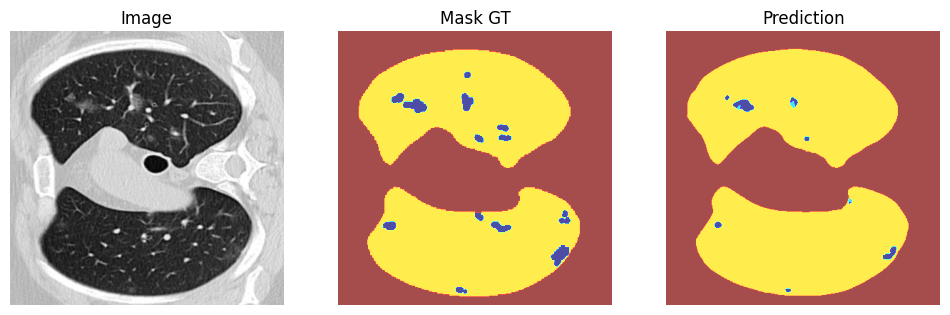

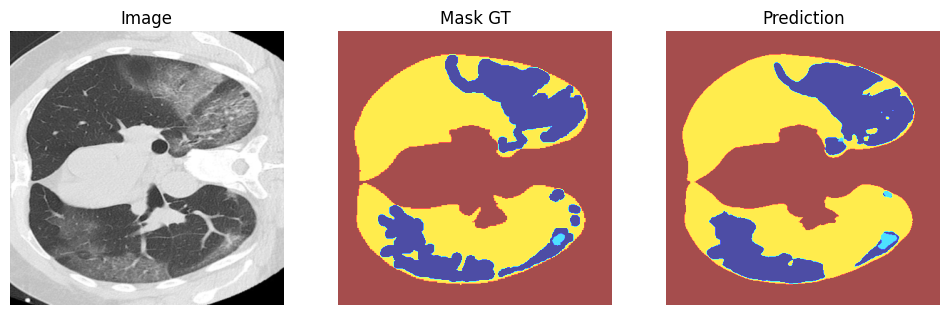

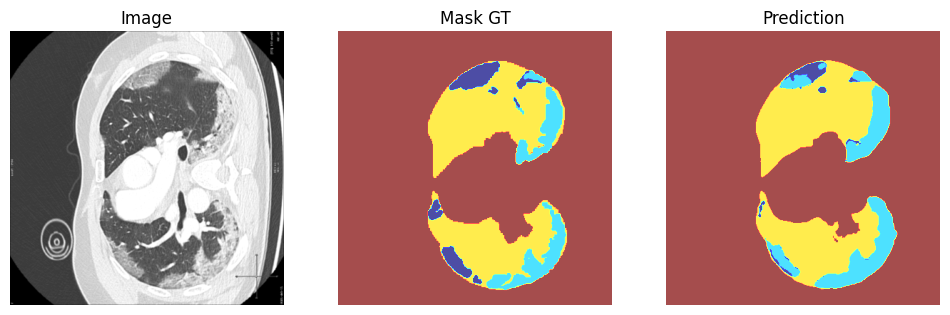

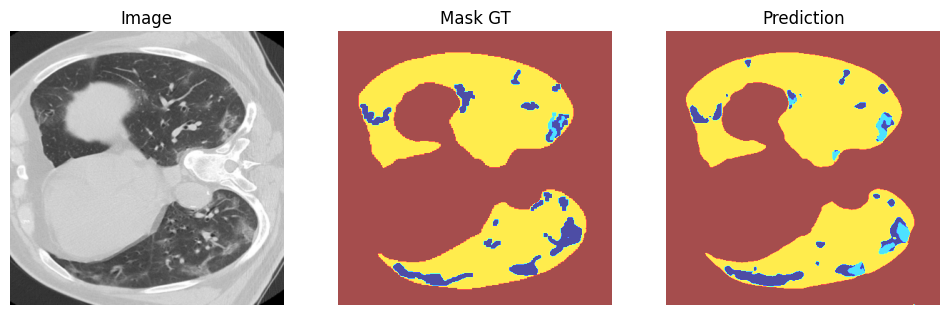

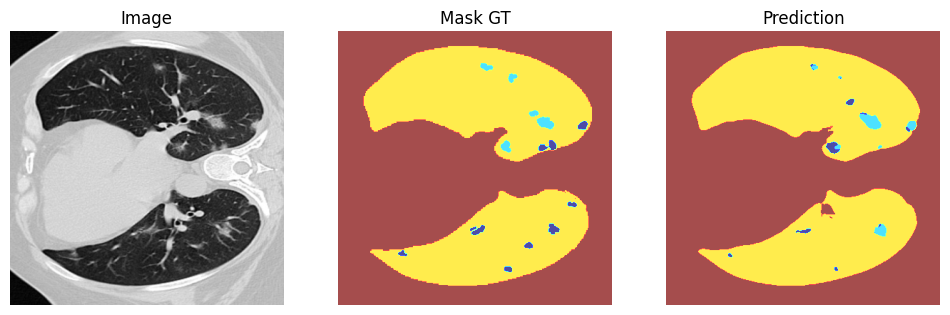

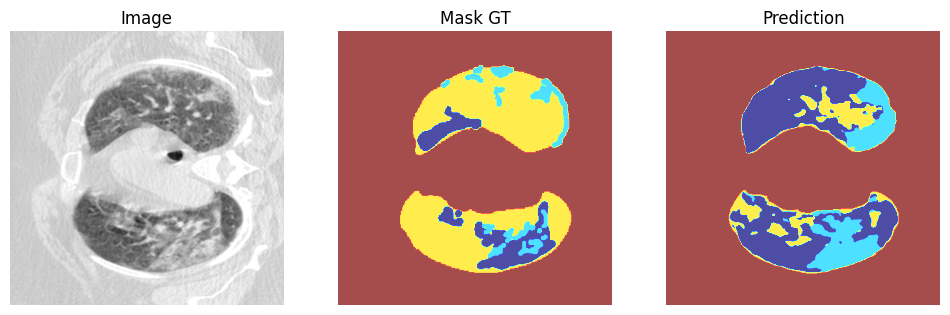

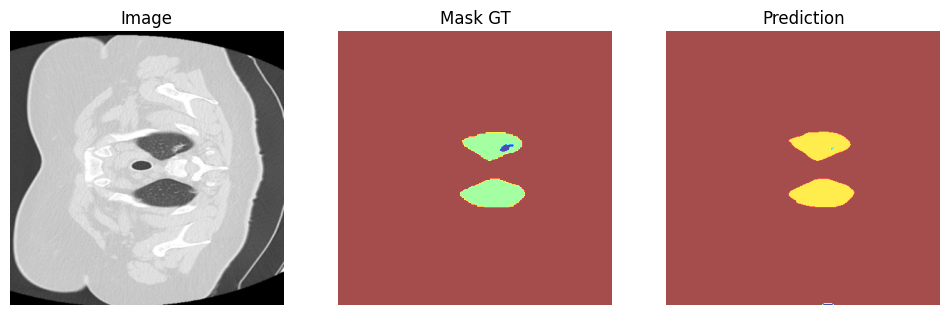

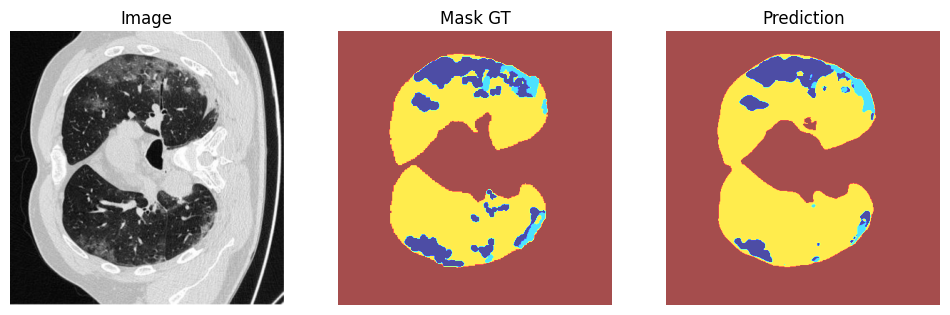

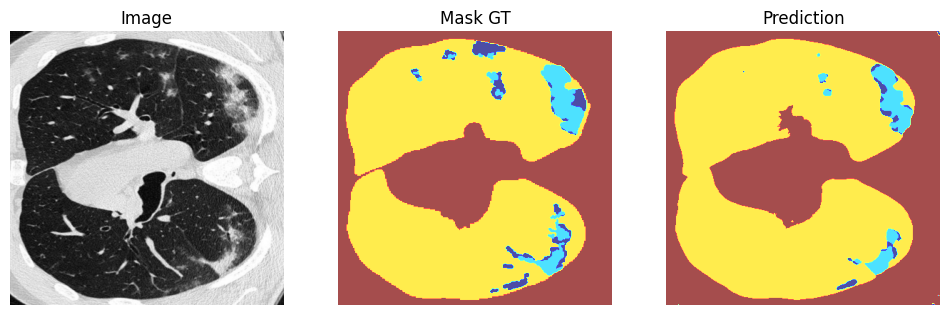

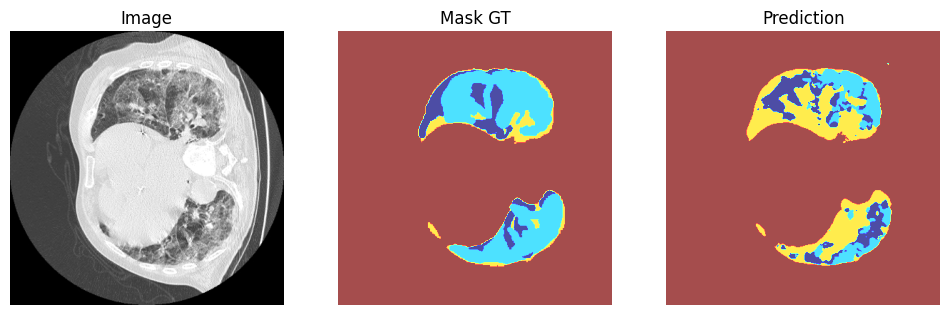

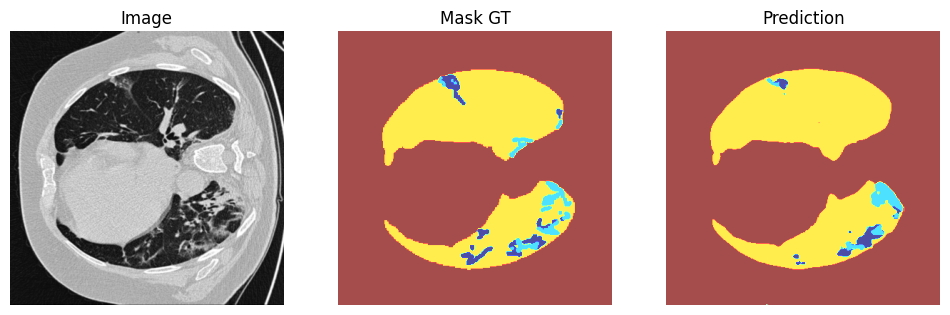

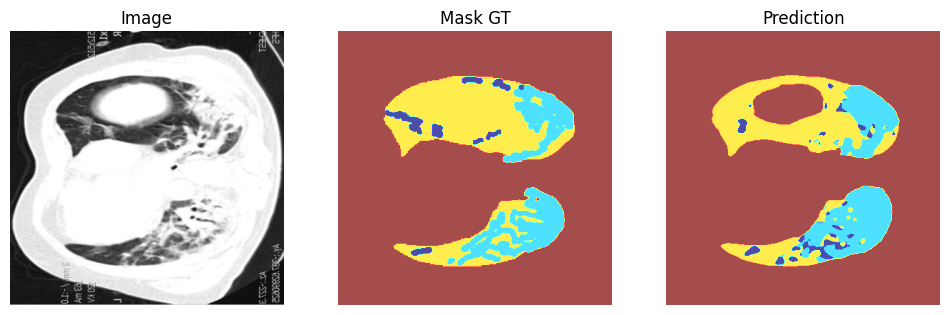

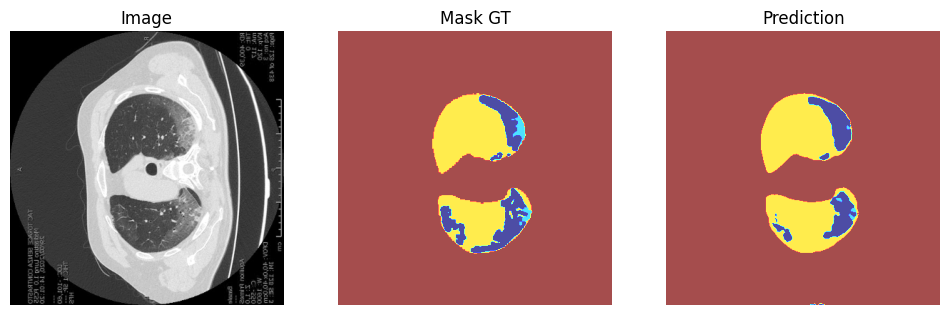

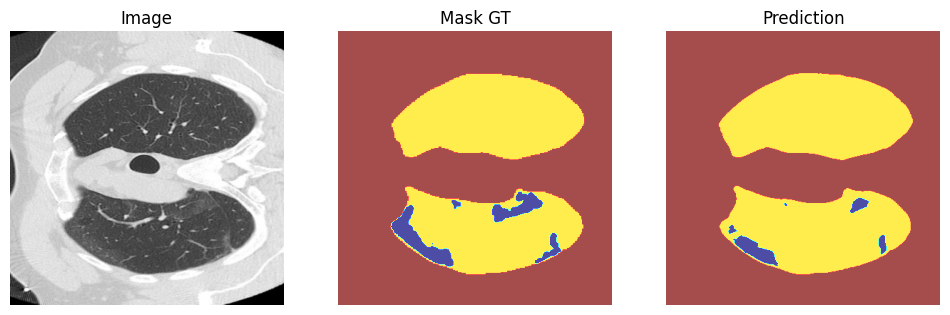

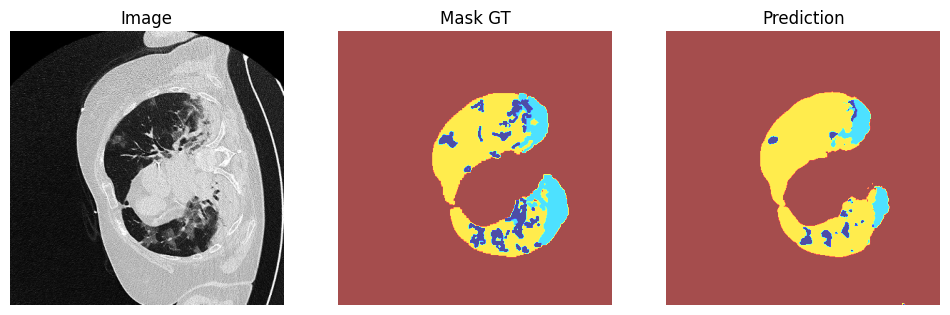

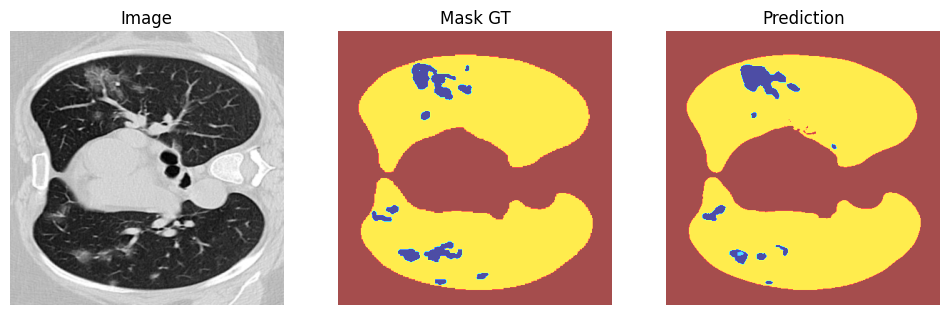

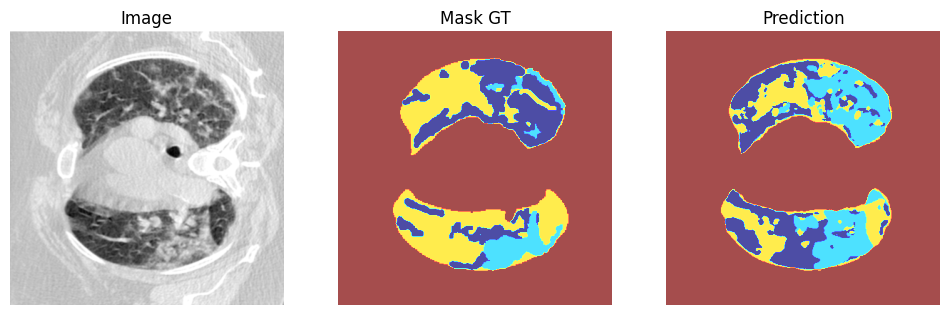

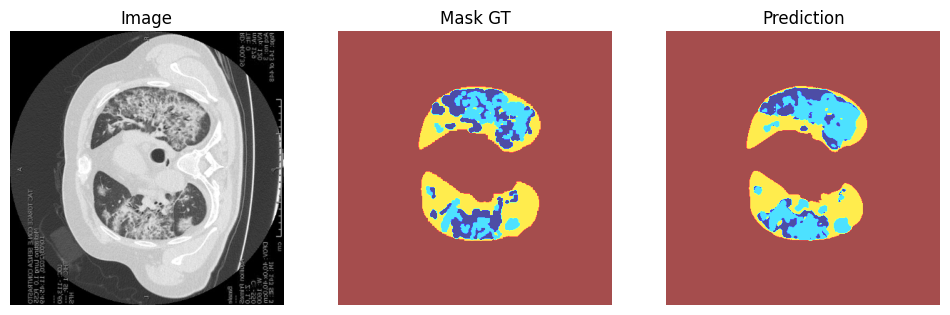

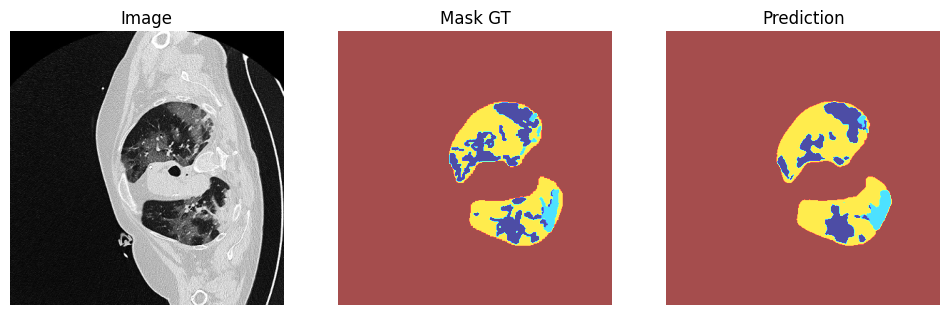

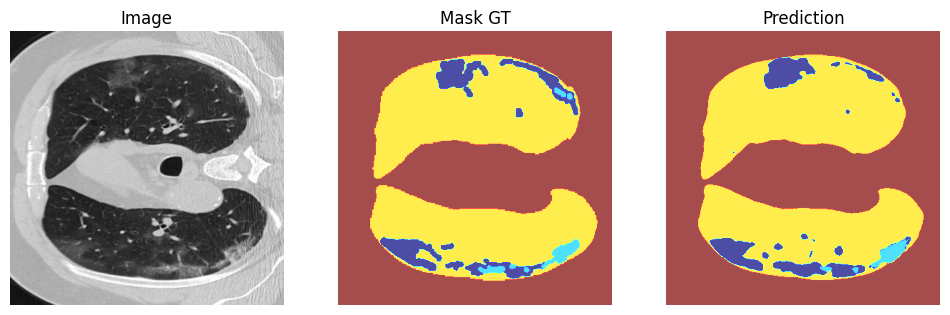

In [27]:
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

@torch.no_grad()
def visualize_batch(x_cpu, y_cpu, pred_cpu, max_images=6):
    n = min(max_images, x_cpu.size(0))
    for i in range(n):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(x_cpu[i,0], cmap="gray"); plt.title("Image"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(y_cpu[i], cmap="jet", alpha=0.7); plt.title("Mask GT"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred_cpu[i], cmap="jet", alpha=0.7); plt.title("Prediction"); plt.axis("off")
        plt.show()

# Loop several val batches so you can inspect more predictions without rerunning training
with torch.no_grad():
    for b_idx, (x, y) in enumerate(val_dl):
        x = x.to(device)
        out = model(x)
        pred = out.argmax(1).cpu()
        visualize_batch(x.cpu(), y, pred, max_images=8)
        if b_idx >= 4:    # show first 5 batches; adjust or remove to see all
            break

## Resultados

### Resultados Cuantitativos

Los resultados de entrenamiento y validación muestran una mejora progresiva del Dice promedio, pasando de 0.36 en la Epoch 1 hasta alcanzar un máximo de 0.84 en la Epoch 41.  

Ejemplo de métricas clave durante el entrenamiento:

| Epoch | Train Loss | Val Loss | Dice Fondo | Dice Pulmón | Dice Lesión 1 | Dice Lesión 2 | Dice Mean |
|-------|------------|----------|------------|-------------|---------------|---------------|-----------|
| 1     | 0.927      | 0.789    | 0.0271     | 0.0338      | 0.3843        | 0.6807        | 0.3663    |
| 5     | 0.691      | 0.570    | 0.0572     | 0.0922      | 0.7543        | 0.9140        | 0.5868    |
| 10    | 0.406      | 0.385    | 0.1864     | 0.3347      | 0.8844        | 0.9861        | 0.7351    |
| 20    | 0.238      | 0.242    | 0.3873     | 0.5443      | 0.9070        | 0.9921        | 0.8145    |
| 32    | 0.193      | 0.202    | 0.4905     | 0.5988      | 0.9139        | 0.9929        | 0.8352    |
| 41    | 0.182      | 0.188    | 0.5857     | 0.6134      | 0.9147        | 0.9932        | **0.8404** |

**Observaciones:**  
- El fondo y el pulmón tuvieron Dice más bajos en las primeras etapas debido a confusiones iniciales del modelo, pero mejoraron progresivamente.  
- Las lesiones (clases 2 y 3) alcanzaron métricas altas (≥0.91) desde epochs intermedias, lo que indica buena sensibilidad para detectar áreas patológicas.  
- La métrica global se estabilizó entre 0.82–0.84, lo que refleja una segmentación robusta en todas las clases.  

---

### Resultados Visuales

A continuación se presentan ejemplos visuales del desempeño del modelo:

1. **Columna 1:** Imagen original (TAC en escala de grises).  
2. **Columna 2:** Máscara real (ground truth).  
3. **Columna 3:** Predicción del modelo.  

Tendencias observadas:  
- El modelo segmenta con alta precisión las áreas pulmonares, incluso en casos con afectación extensa.  
- En lesiones muy pequeñas, existe cierta subsegmentación (falsos negativos).  
- En imágenes con ruido o artefactos, el modelo tiende a sobrepredecir áreas cercanas al borde pulmonar.  

### Conclusiones

- El modelo U-Net++ con CE + Dice + Focal Loss logró un rendimiento sólido, alcanzando un dice score promedio de 0.84 en validación.  
- Las clases minoritarias (lesiones) fueron detectadas de manera efectiva gracias al WeightedRandomSampler y la función de pérdida compuesta.  
- Los principales errores se dieron en:
  - Subsegmentación de lesiones muy pequeñas.  
  - Falsos positivos leves en zonas cercanas a la pleura.  
- Aun así, los resultados son competitivos y muestran que el modelo es clínicamente útil para la segmentación automatizada de lesiones COVID-19.  